In [183]:
import yfinance as yf
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import adfuller, coint
import statsmodels.api as sm

In [141]:
leverage = 10
initial_capital = 200000

## 1. Time Series Prep

- The adjusted closing price amends a stock's closing price to reflect that stock's value after accounting for any corporate actions. It is often used when examining historical returns or doing a detailed analysis of past performance.

In [184]:
end_date = datetime(2019, 12, 31)
start_date = datetime(2014, 1, 1)

# Download data as dataframe
ETF = yf.download('SPTL', start=start_date, end=end_date).reset_index()
EFFR = web.DataReader('EFFR', 'fred', start_date, end_date).dropna().reset_index().rename({'DATE':'Date'}, axis = 1)

[*********************100%***********************]  1 of 1 completed


In [185]:
# The EFFR data will be Nan at weekends or some other federal holidays
# The weekends are not tradings days and hence they are dropped. Otherwise, use forward fill method
# Assuing the EFFR data to the same as the previous day
df = pd.merge(left = ETF, right = EFFR, on = 'Date', how = 'left').ffill(axis = 0)

df = df[['Date', 'Close', 'EFFR']]

In [186]:
df['EFFR'] = pd.to_numeric(df['EFFR'], errors='coerce')
df['EFFR'] = df['EFFR'] / 100
# Adjust the annual risk-free rate to make it a daily rate
df['Daily_EFFR'] = df['EFFR']/(252*100)
df.head()

,Date,Close,EFFR,Daily_EFFR
0,2014-01-02,30.055,0.0008,3.174603e-08
1,2014-01-03,30.035,0.0008,3.174603e-08
2,2014-01-06,30.160,0.0008,3.174603e-08
3,2014-01-07,30.260,0.0007,2.777778e-08
4,2014-01-08,30.150,0.0007,2.777778e-08


In [187]:
# Calculate the daily execess return per unit SPTL
df['Daily_return'] = df['Close'].pct_change(1, fill_method='ffill')
df['Daily_excess_return'] = df['Close'].pct_change(1, fill_method='ffill') - df['Daily_EFFR']
df['Daily_excess_leverage_return'] = df['Daily_excess_return'] * leverage
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                         0.0009
Daily_EFFR                                      0.0
Daily_return                               0.005885
Daily_excess_return                        0.005885
Daily_excess_leverage_return               0.058849
Name: 196, dtype: object

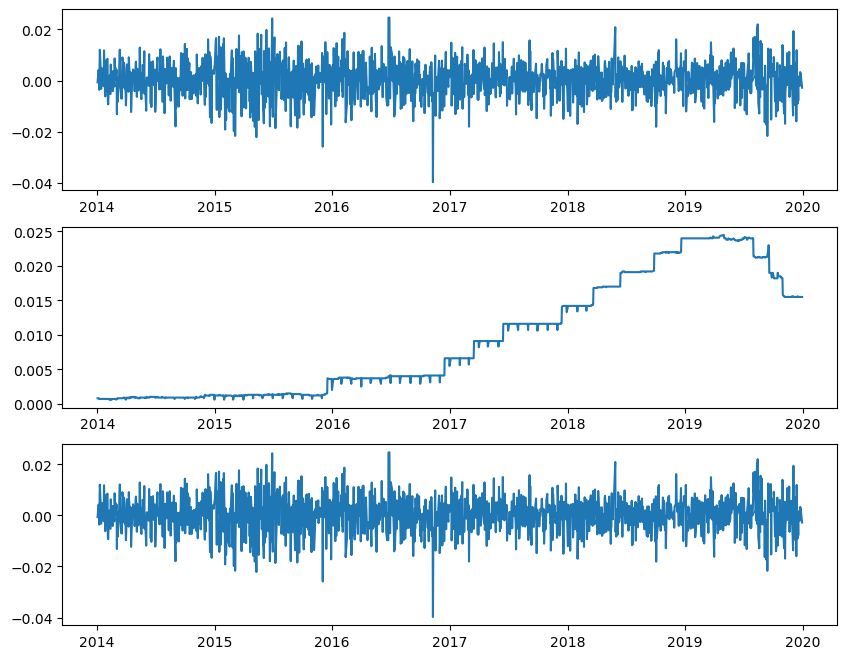

In [188]:
fig, ax = plt.subplots(3, 1, figsize = (10, 8))

ax[0].plot(df['Date'], df['Daily_return'])
ax[1].plot(df['Date'], df['EFFR'])
ax[2].plot(df['Date'], df['Daily_excess_return'])

In [147]:
df.iloc[196]

Date                            2014-10-13 00:00:00
Close                                     35.040001
EFFR                                         0.0009
Daily_EFFR                                      0.0
Daily_return                               0.005885
Daily_excess_return                        0.005885
Daily_excess_leverage_return               0.058849
Name: 196, dtype: object

## 2. Trading Strategies

### Strategy 1 -  Trend following strategy

In [191]:
MA = 20
df['MA'] = df['Close'].rolling(MA).mean()
df['Log_daily_return'] = np.log(df['Close']/df['Close'].shift(1))
df['Ratio'] = df['Close'] / df['MA']

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_20505/2125766768.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


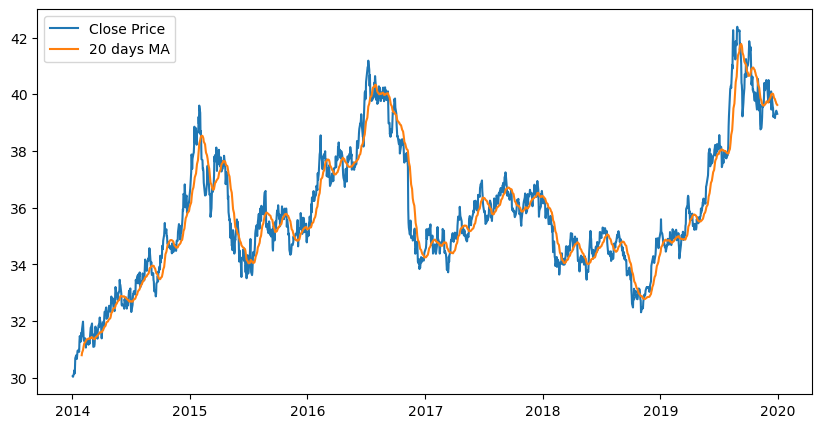

In [192]:
fig, ax = plt.subplots(1, 1, figsize = (10, 5))
ax.plot(df['Date'], df['Close'], label = 'Close Price')
ax.plot(df['Date'], df['MA'], label = f'{MA} days MA')
plt.legend()
fig.show()


In [193]:
train_size = int(0.8 * len(df))
train_set = df[:train_size]
test_set = df[train_size:]

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_20505/4243933833.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


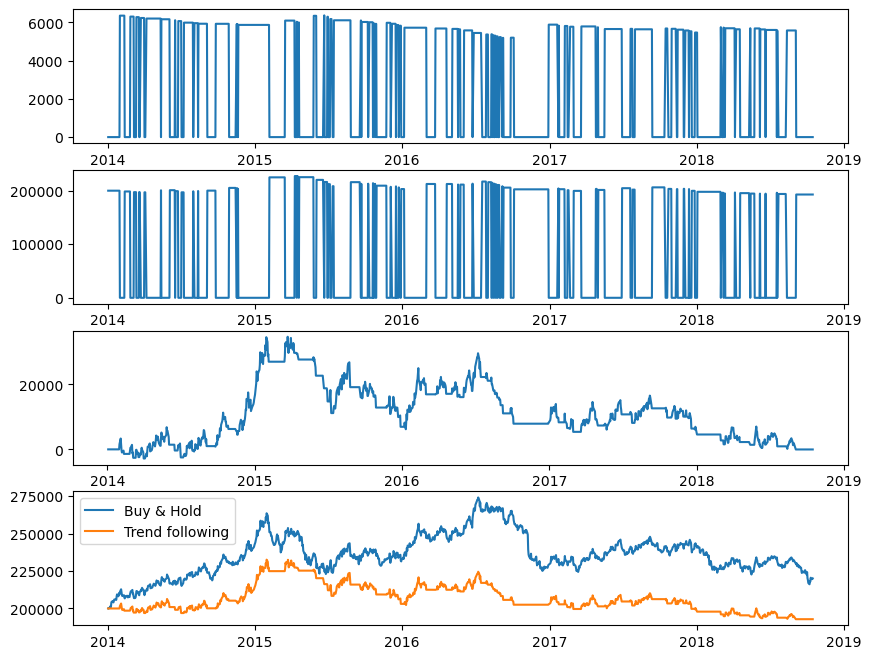

In [215]:
train_set = train_set.copy()

# TRADING: TREND FOLLOWING 

position = np.zeros(len(train_set))   # Initialize an array to store weights of the asset in the portfolio
cash = np.zeros(len(train_set))  # Initialize an array to store the cash value in the portfolio
buy_signal = np.full((len(train_set),), np.nan)
sell_signal = np.full((len(train_set),), np.nan)

cash[0] = 200000  # Start with a cash amount of 100

price = np.array(train_set['Close'])
MA = np.array(train_set['MA'])

# Iterate over the price series
for i, spot_price in enumerate(price[:-1], 0):

    # If the current price is greater than the moving average, buy the asset
    if MA[i] < spot_price:
        if cash[i] != 0:
            buy_signal[i] = 1       
        position[i+1] = cash[i] / spot_price + position[i]  # Invest all cash into the asset
        cash[i+1] = 0  # No cash left
        
    # If the current price is less than the moving average, sell the asset
    elif MA[i] > spot_price:
        if cash[i] == 0:
            buy_signal[i] = -1
        cash[i+1] = position[i] * spot_price + cash[i]  # Convert all holdings of the asset into cash
        position[i+1] = 0  # No holdings in the asset
        
    else:
        position[i+1] = position[i]  # Keep the portfolio unchanged
        cash[i+1] = cash[i]
    
train_set['Holding'], train_set['Cash'], train_set['Buy_signal'], train_set['Sell_signal'] = position, cash, buy_signal, sell_signal
train_set['Theta'] = train_set['Holding'] * train_set['Close'] 
train_set['PnL'] = train_set['Daily_excess_return'] * train_set['Theta']
train_set['Cumulative_PnL'] = train_set['PnL'].cumsum()

fig, ax = plt.subplots(4, 1, figsize = (10, 8))
ax[0].plot(train_set['Date'], train_set['Holding'], label = 'Holding')
ax[1].plot(train_set['Date'], train_set['Cash'], label = 'Cash')
ax[2].plot(train_set['Date'], train_set['Cumulative_PnL'], label = 'Trend Following Strategy')
ax[3].plot(train_set['Date'], cash[0]/ price[0] * price, label = 'Buy & Hold')
ax[3].plot(train_set['Date'], train_set['Theta'] + train_set['Cash'], label = 'Trend following')

# plt.plot(train_set['Date'], )
ax[3].legend()

fig.show()

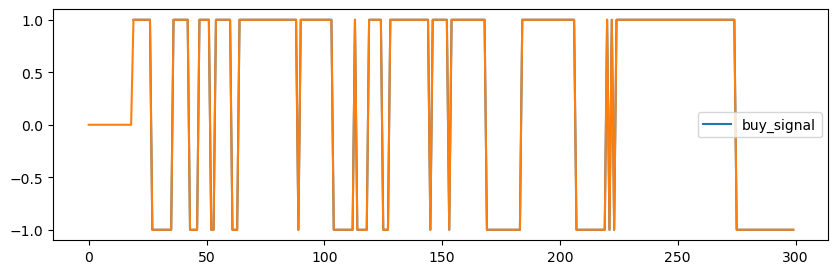

In [229]:
fig, ax = plt.subplots(1, 1, figsize = (10, 3))
train_set['Buy_signal'] = train_set['Buy_signal'].ffill()
ax.plot(train_set['Buy_signal'][:300], label = 'buy_signal')
ax.plot(train_set['Position'][:300].fillna(0))
ax.legend()

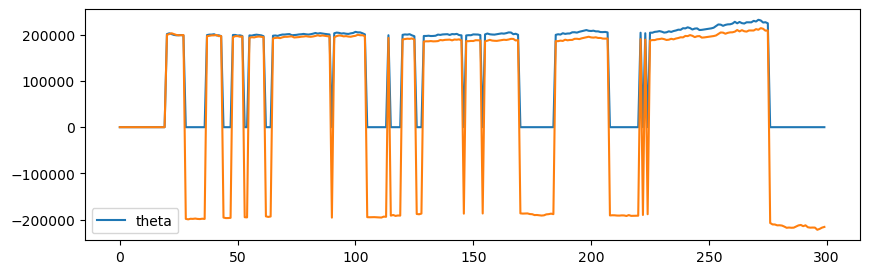

In [234]:
fig, ax = plt.subplots(1, 1, figsize = (10, 3))
# train_set['Theta'] = train_set['Buy_signal'].ffill()
ax.plot(train_set['Theta'][:300], label = 'theta')
ax.plot(result['theta'][:300])
ax.legend()

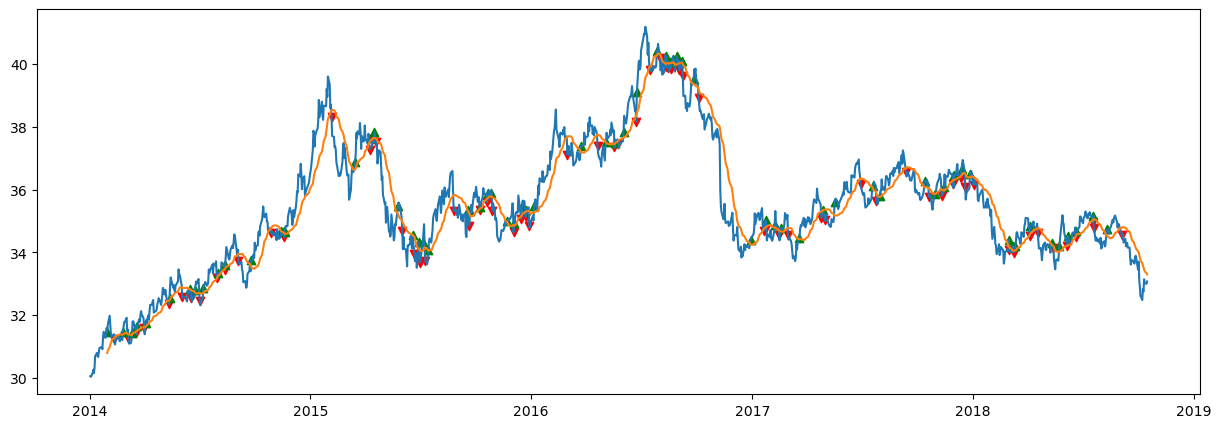

In [152]:
fig, ax = plt.subplots(1, 1, figsize = (15, 5))
plt.plot(train_set['Date'], train_set['Close'])
plt.plot(train_set['Date'], train_set['MA'])
plt.scatter(train_set['Date'], train_set['Sell_signal'], label='Sell Signal', marker='v', color='red', alpha=1)
plt.scatter(train_set['Date'], train_set['Buy_signal'], label='Buy Signal', marker='^', color='green', alpha=1)


In [153]:
train_set.columns

Index(['Date', 'Close', 'EFFR', 'Daily_EFFR', 'Daily_return',
       'Daily_excess_return', 'Daily_excess_leverage_return', 'MA',
       'Log_daily_return', 'Ratio', 'Holding', 'Cash', 'Buy_signal',
       'Sell_signal', 'Theta', 'PnL', 'Cumulative_PnL'],
      dtype='object')

In [195]:


def compute_position_value(df: pd.DataFrame, signal: np.array, initial_capital: int, leverage: int) -> dict:

    N = len(df)
    
    price = df['Close'].to_numpy()
    daily_EFFR = df['Daily_EFFR'].to_numpy()
    daily_excess_return = df['Daily_excess_return'].to_numpy()

    unit = np.zeros(N)

    L = leverage # Leverage
    M = np.zeros(N) # Margin series

    # V: total value of the holdings
    # Vcap: unused capital (earn risk-free date)
    # Vtot: total value (V + Vcap)

    V, Vcap = np.zeros(N), np.zeros(N)
    dV, dVcap, dVtot = np.zeros(N), np.zeros(N), np.zeros(N)

    V[0] = initial_capital
    Vtot = V + Vcap

    # theta: dollar value of ETF held at time t (How much money are you invested into the ETF)
    theta = np.zeros(N)

    indice = []
    for t, signal in enumerate(signal[:-1], 1):
        
        theta[t] = Vtot[t-1] * L * signal
        # Check if result is NaN
        if np.isnan(theta[t]):
            indice.append(t)

        unit[t] = theta[t] / price[t]
        dV[t] = daily_excess_return[t] * theta[t]
        V[t] = V[t-1] + dV[t]

        M[t] = np.abs(theta[t])/L # Total margin used

        dVcap[t] = (Vtot[t] - M[t]) * daily_EFFR[t] 
        Vcap[t] = Vcap[t-1] + dVcap[t]

        dVtot[t] = dV[t] + dVcap[t]
        Vtot[t] = Vtot[t-1] + dVtot[t]
        

    return {'Vtot': Vtot,'Vcap': Vcap, 'V': V,
            'dVtot': dVtot,'dVcap': dVcap, 'dV': dV,
            'theta': theta, 'M': M}
    
    

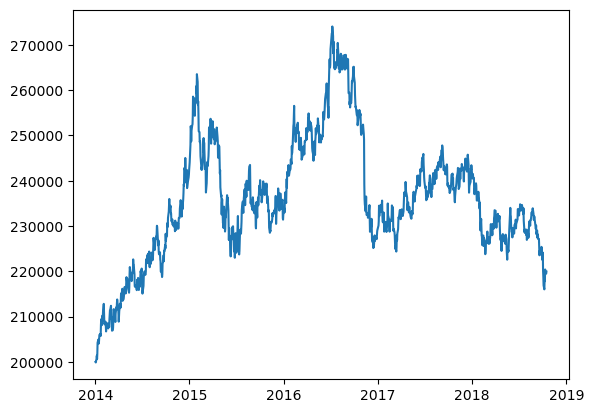

In [182]:
result = compute_position_value(df = train_set, signal = np.ones(len(train_set)), initial_capital = 200000, leverage = 1) 

plt.plot(train_set['Date'], result['Vtot'])

In [230]:

position = np.zeros(len(train_set))   # Initialize an array to store weights of the asset in the portfolio
cash = np.zeros(len(train_set))  # Initialize an array to store the cash value in the portfolio

leverage = 1
cash[0] = 200000 * leverage

# Explicitly create a copy of the DataFrame to avoid SettingWithCopyWarning
train_set = train_set.copy()

# If the current price is greater than the moving average, buy the asset
train_set.loc[:, 'Position'] = np.where(train_set['Close'] > train_set['MA'], 1, np.nan)
train_set.loc[:, 'Position'] = np.where(train_set['Close'] < train_set['MA'], -1, train_set['Position'])
train_set.loc[:, 'Position'] = train_set['Position'].ffill()

train_set.head()


,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,MA,Log_daily_return,Ratio,Holding,Cash,Buy_signal,Sell_signal,Theta,PnL,Cumulative_PnL,Position
0,2014-01-02,30.055,0.0008,3.174603e-08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,200000.0,NaN,NaN,0.0,NaN,NaN,NaN
1,2014-01-03,30.035,0.0008,3.174603e-08,-0.000665,-0.000665,-0.006655,NaN,-0.000666,NaN,0.0,200000.0,NaN,NaN,0.0,-0.0,0.0,NaN
2,2014-01-06,30.160,0.0008,3.174603e-08,0.004162,0.004162,0.041618,NaN,0.004153,NaN,0.0,200000.0,NaN,NaN,0.0,0.0,0.0,NaN
3,2014-01-07,30.260,0.0007,2.777778e-08,0.003316,0.003316,0.033156,NaN,0.003310,NaN,0.0,200000.0,NaN,NaN,0.0,0.0,0.0,NaN
4,2014-01-08,30.150,0.0007,2.777778e-08,-0.003635,-0.003635,-0.036352,NaN,-0.003642,NaN,0.0,200000.0,NaN,NaN,0.0,-0.0,0.0,NaN


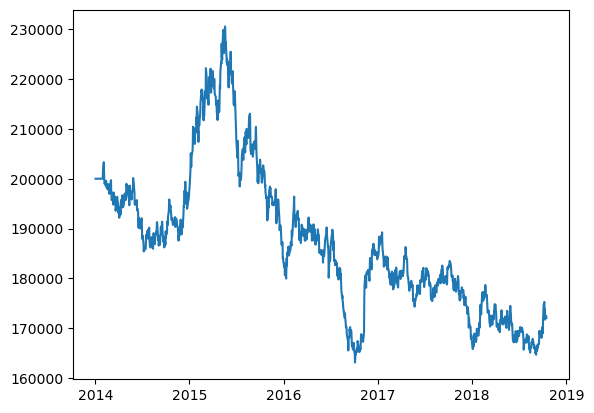

In [231]:
result = compute_position_value(df = train_set, signal = np.array(train_set['Position'].fillna(0)), initial_capital = 200000, leverage = 1) 

plt.plot(train_set['Date'], result['Vtot'])

[0.97463008 0.98132494 1.00259175 1.02154279 1.02874921]


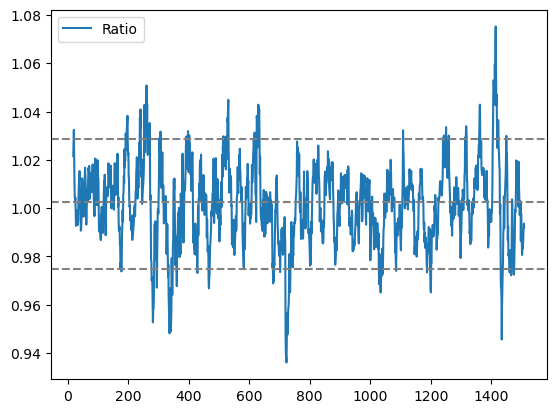

In [235]:
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['Ratio'].dropna(), percentiles)
print(p)
percentiles = [5, 10, 50, 90, 95]
p = np.percentile(df['Ratio'].dropna(), percentiles)
df['Ratio'].dropna().plot(legend = True)
plt.axhline(p[0], c= (.5,.5,.5), ls='--')
plt.axhline(p[2], c= (.5,.5,.5), ls='--')
plt.axhline(p[-1], c= (.5,.5,.5), ls='--')

/var/folders/l5/2302s0j90898y2c73n3g1wmr0000gn/T/ipykernel_20505/1738106997.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


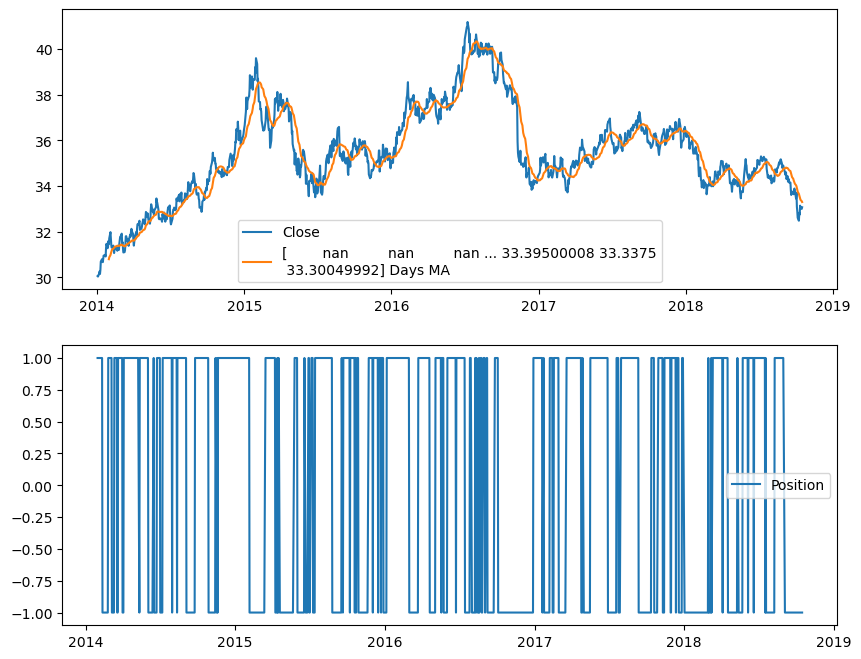

In [161]:
fig, ax = plt.subplots(2, 1, figsize = (10, 8))
ax[0].plot(train_set['Date'], train_set['Close'], label = 'Close')
ax[0].plot(train_set['Date'], train_set['MA'], label = f'{MA} Days MA')
ax[0].legend()
ax[1].plot(train_set['Date'], train_set['Position'], label = 'Position')
ax[1].legend()

fig.show()

In [162]:
train_set['Strat_return'] = train_set['Daily_return'] * train_set['Position'].shift()
train_set['Cumulative_return'] = (1 + train_set['Strat_return'].fillna(0)).cumprod()
train_set['Total_value'] = 200000 * train_set['Cumulative_return']
train_set

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,MA,Log_daily_return,Ratio,...,Cash,Buy_signal,Sell_signal,Theta,PnL,Cumulative_PnL,Position,Strat_return,Cumulative_return,Total_value
0,2014-01-02,30.055000,0.0008,3.174603e-08,NaN,NaN,NaN,NaN,NaN,NaN,...,200000.000000,NaN,NaN,0.0,NaN,NaN,NaN,NaN,1.000000,200000.000000
1,2014-01-03,30.035000,0.0008,3.174603e-08,-0.000665,-0.000665,-0.006655,NaN,-0.000666,NaN,...,200000.000000,NaN,NaN,0.0,-0.0,0.000000,NaN,NaN,1.000000,200000.000000
2,2014-01-06,30.160000,0.0008,3.174603e-08,0.004162,0.004162,0.041618,NaN,0.004153,NaN,...,200000.000000,NaN,NaN,0.0,0.0,0.000000,NaN,NaN,1.000000,200000.000000
3,2014-01-07,30.260000,0.0007,2.777778e-08,0.003316,0.003316,0.033156,NaN,0.003310,NaN,...,200000.000000,NaN,NaN,0.0,0.0,0.000000,NaN,NaN,1.000000,200000.000000
4,2014-01-08,30.150000,0.0007,2.777778e-08,-0.003635,-0.003635,-0.036352,NaN,-0.003642,NaN,...,200000.000000,NaN,NaN,0.0,-0.0,0.000000,NaN,NaN,1.000000,200000.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,2018-10-10,32.750000,0.0218,8.650794e-07,-0.002437,-0.002438,-0.024377,33.5100,-0.002440,0.977320,...,192852.501895,NaN,NaN,0.0,-0.0,-29.558827,-1.0,0.002437,0.869387,173877.393355
1203,2018-10-11,33.139999,0.0218,8.650794e-07,0.011908,0.011908,0.119075,33.4520,0.011838,0.990673,...,192852.501895,NaN,NaN,0.0,0.0,-29.558827,-1.0,-0.011908,0.859034,171806.795575
1204,2018-10-12,33.009998,0.0218,8.650794e-07,-0.003923,-0.003924,-0.039236,33.3950,-0.003930,0.988471,...,192852.501895,NaN,NaN,0.0,-0.0,-29.558827,-1.0,0.003923,0.862404,172480.756569
1205,2018-10-15,33.000000,0.0218,8.650794e-07,-0.000303,-0.000304,-0.003038,33.3375,-0.000303,0.989876,...,192852.501895,NaN,NaN,0.0,-0.0,-29.558827,-1.0,0.000303,0.862665,172532.998864


In [164]:
def trade_trend_following(row):
    
    next_position, next_cash = 0, 0
    # If price rise above the MA, buy all with cash
    if row['Close'] > row['MA']:
        next_position = row['Cash'] / row['Close'] + row['Position']
        next_cash = 0
    elif row['Close'] < row['MA']:
        next_position = 0
        next_cash = row['Close'] * row['Position'] + row['Cash']
    elif row['Close'] == row['MA']:
        next_position = row['Position']
        next_cash = row['Cash']
        
    return next_position, next_cash

train_set['Cash'], train_set['Holding'] = np.zeros(len(train_set)), np.zeros(len(train_set))
train_set.loc[0, 'Cash'] = 200000


In [236]:
def trade_trend_following(row):
    next_position, next_cash = 0, 0
    # If price rises above the MA, buy all with cash
    if row['Close'] > row['MA']:
        next_position = row['Cash'] / row['Close'] + row['Position']
        next_cash = 0
    elif row['Close'] < row['MA']:
        next_position = 0
        next_cash = row['Close'] * row['Position'] + row['Cash']
    elif row['Close'] == row['MA']:
        next_position = row['Position']
        next_cash = row['Cash']
        
    return pd.Series([next_cash, next_position])

# Initialize the 'Cash' and 'Holding' columns
train_set['Cash'], train_set['Holding'] = np.zeros(len(train_set)), np.zeros(len(train_set))
train_set.loc[0, 'Cash'] = 200000

# Apply the function and assign the results
result = train_set.apply(trade_trend_following, axis=1)
train_set['Cash'], train_set['Holding'] = result[0], result[1]


In [237]:
train_set

,Date,Close,EFFR,Daily_EFFR,Daily_return,Daily_excess_return,Daily_excess_leverage_return,MA,Log_daily_return,Ratio,Holding,Cash,Buy_signal,Sell_signal,Theta,PnL,Cumulative_PnL,Position
0,2014-01-02,30.055000,0.0008,3.174603e-08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.000000,NaN,NaN,0.0,NaN,NaN,NaN
1,2014-01-03,30.035000,0.0008,3.174603e-08,-0.000665,-0.000665,-0.006655,NaN,-0.000666,NaN,0.0,0.000000,NaN,NaN,0.0,-0.0,0.000000,NaN
2,2014-01-06,30.160000,0.0008,3.174603e-08,0.004162,0.004162,0.041618,NaN,0.004153,NaN,0.0,0.000000,NaN,NaN,0.0,0.0,0.000000,NaN
3,2014-01-07,30.260000,0.0007,2.777778e-08,0.003316,0.003316,0.033156,NaN,0.003310,NaN,0.0,0.000000,NaN,NaN,0.0,0.0,0.000000,NaN
4,2014-01-08,30.150000,0.0007,2.777778e-08,-0.003635,-0.003635,-0.036352,NaN,-0.003642,NaN,0.0,0.000000,NaN,NaN,0.0,-0.0,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1202,2018-10-10,32.750000,0.0218,8.650794e-07,-0.002437,-0.002438,-0.024377,33.5100,-0.002440,0.977320,0.0,-32.750000,-1.0,NaN,0.0,-0.0,-29.558827,-1.0
1203,2018-10-11,33.139999,0.0218,8.650794e-07,0.011908,0.011908,0.119075,33.4520,0.011838,0.990673,0.0,-33.139999,-1.0,NaN,0.0,0.0,-29.558827,-1.0
1204,2018-10-12,33.009998,0.0218,8.650794e-07,-0.003923,-0.003924,-0.039236,33.3950,-0.003930,0.988471,0.0,-33.009998,-1.0,NaN,0.0,-0.0,-29.558827,-1.0
1205,2018-10-15,33.000000,0.0218,8.650794e-07,-0.000303,-0.000304,-0.003038,33.3375,-0.000303,0.989876,0.0,-33.000000,-1.0,NaN,0.0,-0.0,-29.558827,-1.0


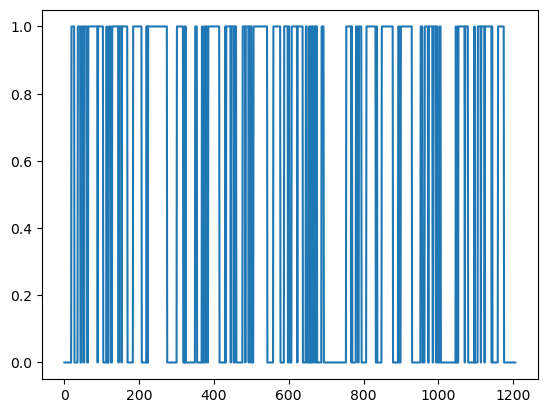

In [238]:
plt.plot(train_set['Holding'])